In [1]:
import os
import os, sys
o_path = os.getcwd()
sys.path.append(o_path)
sys.path.append('..')
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2

from utils.coords import *
from utils.divtree_reader import readDivideTree


%matplotlib inline

del mpl.font_manager.weight_dict['roman']
mpl.font_manager._rebuild()

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 20
plt.rcParams["font.weight"] = 'normal'
mpl.rcParams['image.cmap'] = 'gray'

In [3]:
filesPath = 'dems'

imgOff = 50
edgeColor = (0.75,0,0,1)

files = os.listdir(filesPath)
selected_file = "andes_peru.txt" #"andes-aconcagua.txt" 

fpath = os.path.join(filesPath, selected_file)

fpath, selected_file

('dems/andes_peru.txt', 'andes_peru.txt')

Number of peaks 3083
dems/andes_peru.txt 77.72 0.00


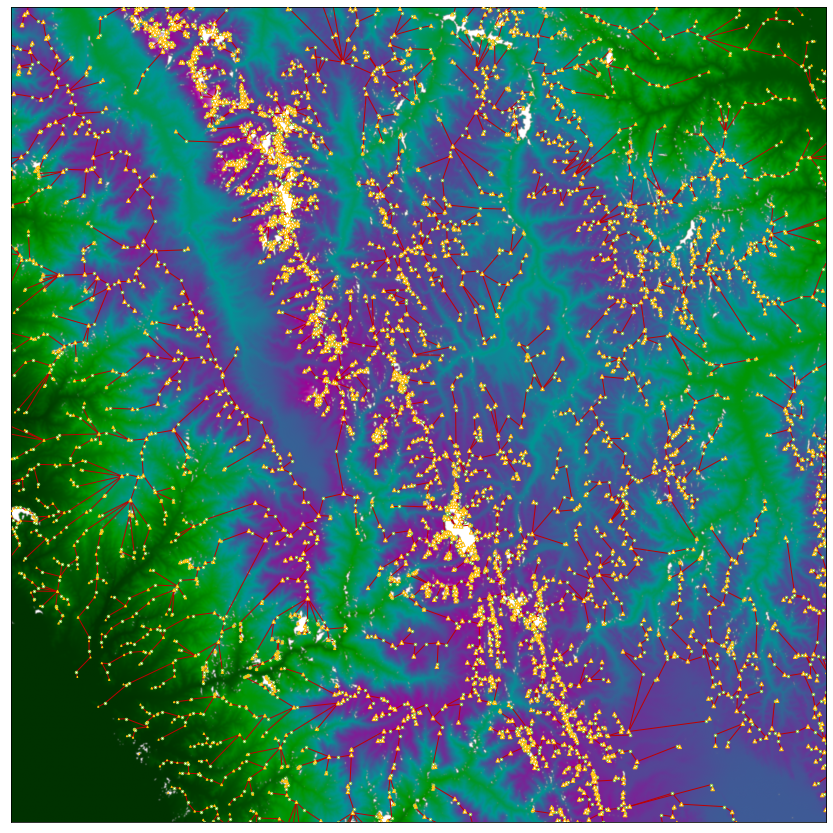

In [6]:
# read divide tree
peakCoords, peakElevs, peakProms, peakDoms, peakIsos, saddleCoords, saddleElevs, saddlePeaks, RidgeTree = readDivideTree(fpath, returnDEMCoords=False)
numPeaks = peakElevs.size
numSaddles = saddlePeaks.shape[0]

print("Number of peaks {}".format(numPeaks))

# read image (16 bit PNG, heights in feet)
img = cv2.imread(fpath.replace('.txt', '.png'), -cv2.IMREAD_ANYDEPTH)

print(fpath, '%.2f'%feet2m(img.max()), '%.2f'%feet2m(img.min()))

# normalize image
img = (img - img.min())/(img.max() - img.min())

fig = plt.figure(figsize=(15, 15*img.shape[0]/img.shape[1]))
ax = fig.add_subplot(111)    

# plot image
ax.imshow(img[...], interpolation='bicubic', zorder=0, cmap='gray')

peakCoords[:,0] =(peakCoords[:,0]/2) * img.shape[1]
peakCoords[:,1] =((peakCoords[:,1]+1)/2) * img.shape[0]
saddleCoords[:,0] =(saddleCoords[:,0]/2) * img.shape[1]
saddleCoords[:,1] =((saddleCoords[:,1]+1)/2) * img.shape[0]

# plot peaks
ax.scatter(peakCoords[:,0], peakCoords[:,1], marker='^', zorder=3,
           s=20*peakElevs/peakElevs.max(), c='white', edgecolors=(1,0.75,0,1), linewidths=1)

# plot saddles
ax.scatter(saddleCoords[:,0], saddleCoords[:,1], marker='o', 
           c='white', edgecolors=(146/255, 208/255, 80/255, 1), s=6, zorder=2)

# plot ridges
for i in range(saddleCoords.shape[0]):
    if saddlePeaks[i,0] < 0 or saddlePeaks[i,1] < 0:
        continue

    p1 = peakCoords[saddlePeaks[i,0]]
    p2 = peakCoords[saddlePeaks[i,1]]
    ps = saddleCoords[i]

    ax.plot([p1[0], ps[0]], [p1[1], ps[1]], color=edgeColor, linewidth=1, zorder=1)
    ax.plot([p2[0], ps[0]], [p2[1], ps[1]], color=edgeColor, linewidth=1, zorder=1)
    
    
# place a text box in upper left in axes coords
#ax.text(0.016, 0.016, f.split('.')[0].replace('-', ' '), transform=ax.transAxes, fontsize=24,
#        verticalalignment='bottom', horizontalalignment='left',
#        bbox=dict(boxstyle='square', facecolor='white', alpha=1))

plt.xlim(peakCoords[:,0].min() + imgOff, peakCoords[:,0].max() - imgOff)
plt.ylim(peakCoords[:,1].max() - imgOff, peakCoords[:,1].min() + imgOff)

ax.set_xticks([])
ax.set_yticks([])
plt.show()

### Build a sampling approach for the divide tree.
We will start from a saddle point and  then iterate over the $saddlePeaks$ structure. Getting a set of saddles is enough to sample a part of the divide tree. 

In [23]:
def sampleTree(size,saddlePeaks, saddleCoords, peakCoords):
    
    peakQueue = []
    saddleQueue = []
    
    visitedSaddles = set()
    visitedPeaks = set()
    
    numSaddles = np.shape(saddlePeaks)[0]
    
    randomStartSaddle = np.random.randint(0,numSaddles)# We start by sampling a saddle node
    p1,p2 =  saddlePeaks[randomStartSaddle] # We get the 2 associated peaks
    
    # Update the queues etc.
    visitedSaddles.add(randomStartSaddle)
    peakQueue.append(p1)
    peakQueue.append(p2)
    
    while len(peakQueue) > 0:
        p = peakQueue.pop(0) # Remove first element of the queue
        
        # Now access the saddles that have this peak linked to it
        s1 = set(np.where(saddlePeaks == p)[0])
        #print("Got this for saddles ",s1)
        
        s1 = s1.difference(visitedSaddles)
        saddleQueue.extend(list(s1))
        
        if len(saddleQueue) > 0:
            s = saddleQueue.pop(0)
            p1, p2 = saddlePeaks[s]
            
            # Update the queues etc.
            visitedSaddles.add(s)
            peakQueue.append(p1)
            peakQueue.append(p2)
        
        if len(visitedSaddles) > size-1:
            break
            
    print("set of saddles ", visitedSaddles)
    return list(visitedSaddles)

In [51]:
def plot_sampled_tree(fpath, saddlePoints):
    
    # read image (16 bit PNG, heights in feet)
    img = cv2.imread(fpath.replace('.txt', '.png'), -cv2.IMREAD_ANYDEPTH)

    print(fpath, '%.2f'%feet2m(img.max()), '%.2f'%feet2m(img.min()))

    # normalize image
    img = (img - img.min())/(img.max() - img.min())

    fig = plt.figure(figsize=(15, 15*img.shape[0]/img.shape[1]))
    ax = fig.add_subplot(111)    

    # plot image
    ax.imshow(img[...], interpolation='bicubic', zorder=0, cmap='gray')

    # plot peaks
    
    peaks_to_draw = saddlePeaks[saddlePoints].reshape(-1)
    print(saddlePeaks[saddlePoints])
    print(set(peaks_to_draw), len(set(peaks_to_draw)))
    ax.scatter(peakCoords[peaks_to_draw][:,0], peakCoords[peaks_to_draw][:,1], marker='^', zorder=3,
               s=30*peakElevs[peaks_to_draw]/peakElevs[peaks_to_draw].max(), c='white', edgecolors=(1,0.75,0,1), linewidths=1)

    # plot saddles
    ax.scatter(saddleCoords[saddlePoints,0], saddleCoords[saddlePoints,1], marker='o', 
               c='white', edgecolors=(146/255, 208/255, 80/255, 1), s=6, zorder=2)

    # plot ridges
    for i in saddlePoints:
        if saddlePeaks[i,0] < 0 or saddlePeaks[i,1] < 0:
            continue
        p1 = peakCoords[saddlePeaks[i][0]]
        p2 = peakCoords[saddlePeaks[i][1]]
        ps = saddleCoords[i]
   
        ax.plot([p1[0], ps[0]], [p1[1], ps[1]], color=edgeColor, linewidth=1, zorder=1)
        ax.plot([p2[0], ps[0]], [p2[1], ps[1]], color=edgeColor, linewidth=1, zorder=1)


    # place a text box in upper left in axes coords
    #ax.text(0.016, 0.016, f.split('.')[0].replace('-', ' '), transform=ax.transAxes, fontsize=24,
    #        verticalalignment='bottom', horizontalalignment='left',
    #        bbox=dict(boxstyle='square', facecolor='white', alpha=1))

    min_x = peakCoords[peaks_to_draw,0].min()#, saddleCoords[saddlePoints,0].min()])
    min_y = peakCoords[peaks_to_draw,1].min()#, saddleCoords[saddlePoints,1].min()])
    max_x = peakCoords[peaks_to_draw,0].max()#, saddleCoords[saddlePoints,0].max()])
    max_y = peakCoords[peaks_to_draw,1].max()#, saddleCoords[saddlePoints,1].max()])
    
    #print(min_x, max_x, img.shape[0] - min_y, img.shape[0] - max_y)
    
    #plt.ylim(peakCoords[peaks_to_draw,0].min() - 200, peakCoords[peaks_to_draw,0].max() + 200)
    #plt.xlim(peakCoords[peaks_to_draw,1].max() - 200, peakCoords[peaks_to_draw,1].min() + 200)
    
    plt.ylim(max(min_y - imgOff, 0), min(max_y + imgOff, 2400))
    plt.xlim(min_x - imgOff, max_x + imgOff)

    #ax.set_xticks([])
    #ax.set_yticks([])
    plt.show()
    
    fig.savefig('divtree_sample.pdf', dpi=300, bbox_inches='tight', pad_inches=0)


set of saddles  {2784, 2785, 2821, 2822, 2791, 2795, 2807, 2829, 2768, 2800, 2806, 2839, 2778, 2780, 2814}
dems/andes_peru.txt 77.72 0.00
[[2871 2878]
 [2867 2882]
 [2883 2907]
 [2907 2910]
 [2879 2882]
 [2899 2878]
 [2890 2907]
 [2918 2907]
 [2864 2867]
 [2882 2883]
 [2898 2899]
 [2927 2907]
 [2868 2871]
 [2878 2882]
 [2904 2899]]
{2882, 2883, 2918, 2890, 2927, 2864, 2910, 2898, 2867, 2899, 2868, 2871, 2904, 2907, 2878, 2879} 16


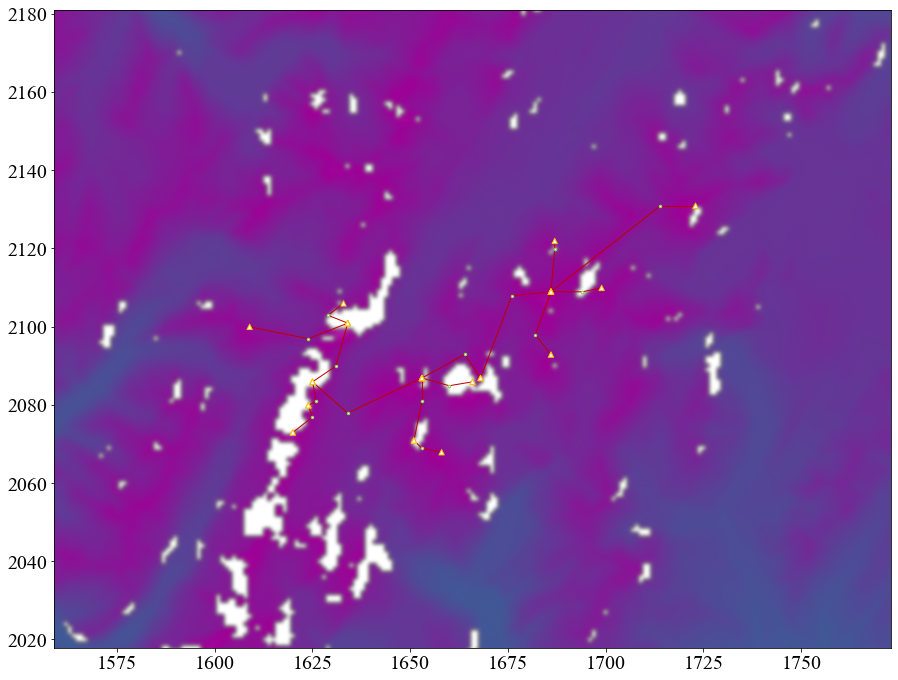

In [52]:
vs = sampleTree(15, saddlePeaks, saddleCoords, peakCoords)
plot_sampled_tree(fpath, vs)